In [2]:
# import pdf2image
import os
from pdf2image import convert_from_path
# import pytesseract as tess
# Importing the Image module from the PIL package to work with images
from PIL import Image
import pandas as pd
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import easyocr
import re
import shutil

In [3]:
path_img = r"D:\git\sipatho-rpa-scan\rename\image"
pdf_origin_path = r"D:\git\sipatho-rpa-scan\rename\raw"
path_renamed = r"D:\git\sipatho-rpa-scan\rename\renamed"
reader = easyocr.Reader(['en'])
crop_name = "image.png"

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [11]:
def copy_and_rename(src_path, dest_path, new_name):
  new_path = f"{dest_path}\\{new_name}"
  # Copy the file
  # shutil.copy(src_path, new_path)

  # Rename the copied file
  print(f"{src_path}")
  #shutil.move(f"{src_path}", new_path)
  shutil.copy(src_path, new_path)

def readOCR(reader, file_name, image_name):
  # Open an image file
  result = reader.readtext(image_name)
  # filter_first = filter(lambda x: re.search("[A-Z]{1,3}[0-9]{8}", x[1]), result_cropped)
  # if len(list(filter_first))==0:
  #   result_rotated = reader.readtext('Cropped_Rotated_Image.jpg')
  #   result = result_rotated
  # else:
  #   result = result_cropped
  found = False
  for detection in result:
    if re.search("[A-Z]{1,3}[0-9]{8}", detection[1]):
      # found = True
      new_name = re.search("[A-Z]{1,3}[0-9]{8}", detection[1]).group(0)
      # print(detection[1])
      #print(path_renamed, new_name)
      copy_and_rename(file_name, path_renamed, new_name+".pdf")
      # 
      found = True

  if found:
    return True, new_name
  else:
    print(file_name)
    return False, file_name

def read_pdf(file_name, reader):
  # Store all pages of one file here:
  pages = []

  if os.path.exists("renamed_file.csv"):
    renamed_df = pd.read_csv("renamed_file.csv")
  else:
    renamed_df = pd.DataFrame(columns=["file_name", "sending_status"])

  if os.path.exists("reject_file.csv"):
    reject_df = pd.read_csv("reject_file.csv")
  else:
    reject_df = pd.DataFrame(columns=["file_name"])

  #################################################

  try:
    # Convert the PDF file to a list of PIL images:
    images = convert_from_path(file_name, poppler_path=r"C:\Users\jewna\Downloads\Release-24.02.0-0\poppler-24.02.0\Library\bin")
    # Extract text from each image:
    for i, image in enumerate(images):
      # Generating filename for each image
      filename = path_img+r"\page_" + str(i) + "_" + os.path.basename(file_name) + ".jpeg" 
      # print(filename) 
      image.save(filename, "JPEG")
      break

  except Exception as e:
    print(str(e))

  img = cv2.imread(filename)
  # print(img.shape) # Print image shape
  # cv2.imshow("original", img)
  
  # Cropping an image
  cropped_image = img[0:300, 1100:1659]
  # Save the cropped image
  cv2.imwrite(crop_name, cropped_image)
  found = False
  found, name = readOCR(reader=reader, file_name=file_name, image_name=crop_name)
  if found:
    print("Found")
    renamed_dict = {"file_name":[name], "sending_status":[False]}
    renamed_df = pd.concat([renamed_df, pd.DataFrame(renamed_dict)])
  
  else:
    image_rotated = cv2.rotate(cropped_image, cv2.ROTATE_180)
    cv2.imwrite(crop_name, image_rotated)
    found, name = readOCR(reader=reader, file_name=file_name, image_name=crop_name)
    if found:
      print("Found")
      renamed_dict = {"file_name":[name], "sending_status":[False]}
      renamed_df = pd.concat([renamed_df, pd.DataFrame(renamed_dict)])
    else:
      cropped_rotated_image = img[2000:2346, 0:600]
      cv2.imwrite(crop_name, image_rotated)
      found, name = readOCR(reader=reader, file_name=file_name, image_name=crop_name)
      if found:
        print("Found")
        renamed_dict = {"file_name":[name], "sending_status":[False]}
        renamed_df = pd.concat([renamed_df, pd.DataFrame(renamed_dict)])
      else:
        image_rotated = cv2.rotate(cropped_rotated_image, cv2.ROTATE_180)
        cv2.imwrite(crop_name, image_rotated)
        found, name = readOCR(reader=reader, file_name=file_name, image_name=crop_name)
        if found:
          print("Found")
          renamed_dict = {"file_name":[name], "sending_status":[False]}
          renamed_df = pd.concat([renamed_df, pd.DataFrame(renamed_dict)])
        else:
          reject_dict = {"file_name":[name]}
          reject_df = pd.concat([reject_df, pd.DataFrame(reject_dict)])
      
  renamed_df.to_csv('renamed_file.csv', index=False)
  reject_df.to_csv('reject_file.csv', index=False)

In [47]:
for file in glob.glob(pdf_origin_path + "\*.pdf"):
  # pdf_name = file
  read_pdf(file, reader)

D:\git\sipatho-rpa-scan\rename\raw\1_rotated.pdf
D:\git\sipatho-rpa-scan\rename\raw\1_rotated.pdf
D:\git\sipatho-rpa-scan\rename\raw\1_rotated.pdf
D:\git\sipatho-rpa-scan\rename\raw\1_rotated.pdf
Found
D:\git\sipatho-rpa-scan\rename\raw\2.pdf
Found
D:\git\sipatho-rpa-scan\rename\raw\3.pdf
Found
D:\git\sipatho-rpa-scan\rename\raw\4.pdf
Found
D:\git\sipatho-rpa-scan\rename\raw\5.pdf
Found
D:\git\sipatho-rpa-scan\rename\raw\6.pdf
Found
D:\git\sipatho-rpa-scan\rename\raw\7.pdf
Found
D:\git\sipatho-rpa-scan\rename\raw\SKM_C300i24021516220.pdf
D:\git\sipatho-rpa-scan\rename\raw\SKM_C300i24021516220.pdf
D:\git\sipatho-rpa-scan\rename\raw\SKM_C300i24021516220.pdf
D:\git\sipatho-rpa-scan\rename\raw\SKM_C300i24021516220.pdf


(2346, 1659, 3)


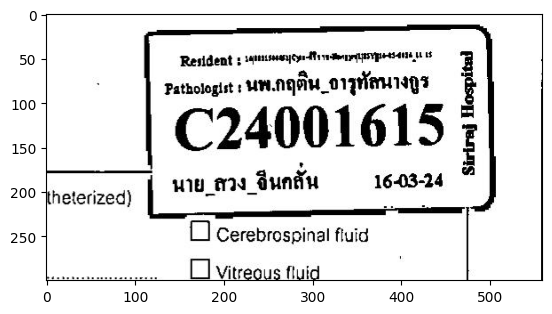

True

In [37]:
img = cv2.imread(r'D:\prawploy.p\scraping\rpa\sipatho-rpa-scan\rename\image\page_0_1.pdf.jpeg')
print(img.shape) # Print image shape
# cv2.imshow("original", img)
 
# Cropping an image
cropped_image = img[0:300, 1100:1659]
 
# Display cropped image
# cv2.imshow("cropped", cropped_image)
plt.imshow(cropped_image)
plt.show()
 
# Save the cropped image
cv2.imwrite("Cropped Image.jpg", cropped_image)

(2338, 1652, 3)


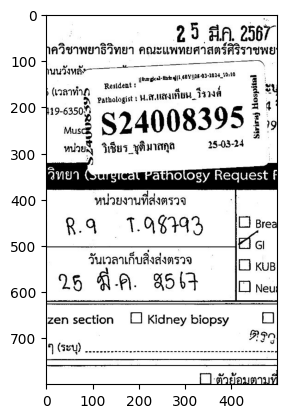

In [12]:
img = cv2.imread(r'D:\git\sipatho-rpa-scan\img0.jpg')
print(img.shape) # Print image shape
# cv2.imshow("original", img)
 
# Cropping an image
cropped_image = img[0:800, 700:1200]
 
# Display cropped image
# cv2.imshow("cropped", cropped_image)
plt.imshow(cropped_image)
plt.show()
 
# Save the cropped image
# cv2.imwrite("Cropped Image.jpg", cropped_image)

(300, 559, 3)


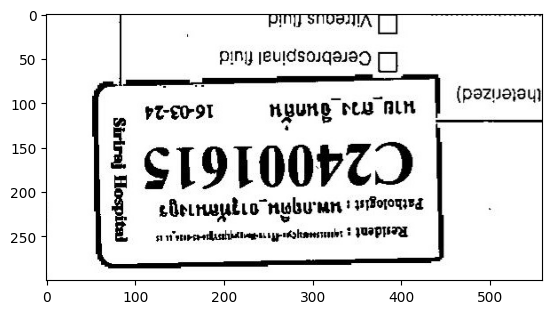

In [38]:
img = cv2.imread(r'D:\prawploy.p\scraping\rpa\sipatho-rpa-scan\rename\Cropped Image_flip.jpg')
print(img.shape) # Print image shape
# cv2.imshow("original", img)
 
# Cropping an image
# cropped_image = img[0:300, 1100:1659]
 
# Display cropped image
# cv2.imshow("cropped", cropped_image)
plt.imshow(img)
plt.show()
 
# Save the cropped image
# cv2.imwrite("Cropped Image.jpg", cropped_image)

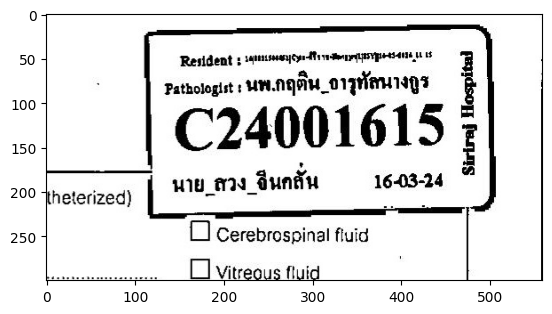

In [43]:
image_rotated = cv2.rotate(img, cv2.ROTATE_180)
plt.imshow(image_rotated)
plt.show()

In [5]:
# Create an OCR reader
reader = easyocr.Reader(['en'])

# Open an image file
result = reader.readtext('test.png')

# Print the extracted text
for detection in result:
    if re.search("[A-Z]{1,3}[0-9]{8}", detection[1]):
        print(detection[1])
        print(re.search("[A-Z]{1,3}[0-9]{8}", detection[1]).group(0))

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


([[169, 25], [385, 25], [385, 45], [169, 45]], 'Vovujuvn75+8183Mu7 n7a7u70787MU7', 0.047691846338741614)
([[386, 30], [448, 30], [448, 38], [386, 38]], 'Anettuan', 0.03035718891818333)
([[447, 27], [541, 27], [541, 43], [447, 43]], 'Iaata3s73Yiu7u7a', 0.03357289555490321)
([[143, 45], [223, 45], [223, 61], [143, 61]], 'angeajiav niv #', 0.03269793835159764)
([[229, 47], [451, 47], [451, 61], [229, 61]], '[NNU7U74n5171 Ouurini? Utjnanizu 07*lnm? 107C0', 0.0011138622121163418)
([[540, 54], [572, 54], [572, 60], [540, 60]], 'PRldnr;', 0.0011418162264687866)
([[573, 47], [672, 47], [672, 56], [573, 56]], '7 tnawltiadtttt ifQult', 0.0002492843710067811)
([[143, 65], [225, 65], [225, 79], [143, 79]], 'YDTu aTJ? Im', 0.006918757664478231)
([[228, 68], [256, 68], [256, 76], [228, 76]], '0-7410', 0.9592192900151337)
([[257, 67], [349, 67], [349, 81], [257, 81]], '-6325 , 6356 (737x-n7t', 0.031021678570152575)
([[369, 67], [391, 67], [391, 79], [369, 79]], '80)', 0.12898841754320212)
([[430, 66]

In [12]:
import sys, fitz
def check_page(page):
  text = page.get_text()
  return len(text.strip()) == 0
def remove_empty_page(inputfile_path):
  # inputfile_path = r"D:\git\sipatho-rpa-scan\rename\added_blankpage.pdf"
  # outputfile_path = r"D:\git\sipatho-rpa-scan\rename\editted.pdf"
  temp_name = inputfile_path.split('\\')[-1].split('.')[0]
  temp_file = f'.\\{temp_name}_temp_pdf.png'
  images = convert_from_path(inputfile_path, fmt='png',poppler_path=r"C:\Users\jewna\Downloads\Release-24.02.0-0\poppler-24.02.0\Library\bin")
  input_pdf = fitz.open(inputfile_path)
  output_pdf = fitz.open()
  for pgno in range(input_pdf.page_count):
    # print(pgno)
    page = input_pdf[pgno]
    if not check_page(page):
      output_pdf.insert_pdf(input_pdf,from_page=pgno,to_page = pgno)
    else:
      print('Page No:',pgno)
      # pix = page.get_pixmap()
      # pix.save(temp_file)
      img_page = images[pgno]
      img_page.save(temp_file)
      result = reader.readtext(temp_file, detail=0)
      print('Success to read')
      if len(result) > 0:
        output_pdf.insert_pdf(input_pdf,from_page=pgno,to_page = pgno)
  output_pdf.save(inputfile_path + "noblank.pdf")
  output_pdf.close()
  input_pdf.close()
  

In [2]:
from multiprocessing import Process
import glob

p = Process(target=remove_empty_page, args=glob.glob(pdf_origin_path + r"\*.pdf"))
p.start()
p.join()

NameError: name 'pdf_origin_path' is not defined

In [13]:
for file in glob.glob(pdf_origin_path + r"\*.pdf"):
    remove_empty_page(file)

Page No: 0
Success to read
Page No: 1
Success to read
Page No: 2
Success to read
Page No: 3
Success to read
Page No: 4
Success to read
Page No: 0
Success to read
Page No: 1
Success to read
Page No: 2
Success to read
Page No: 3
Success to read
Page No: 0
Success to read
Page No: 1
Success to read
Page No: 2
Success to read
Page No: 3
Success to read
Page No: 4
Success to read
Page No: 0
Success to read
Page No: 1
Success to read
Page No: 2
Success to read
Page No: 3
Success to read
Page No: 4
Success to read
Page No: 5
Success to read
Page No: 6
Success to read
Page No: 7
Success to read
Page No: 8
Success to read
Page No: 0


KeyboardInterrupt: 